<a href="https://colab.research.google.com/github/awitz23/master_thesis/blob/main/working_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#dependencies

In [1]:
!pip install scikit-learn
from sklearn.ensemble import RandomForestClassifier


In [2]:
!pip install pm4py
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import os
import sys
import pm4py
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from tqdm.auto import tqdm
# Pfad zu einem Ordner mit mehreren Dateien


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 39.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26094 sha256=027acbe5158f76d53505f75fa655b59430db69a7e491e150f12148ecffd421dd
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
  Created wheel for stringdist: filename=StringDist-1.0.9-cp310-cp310-linux_x86_64.whl size=16968 sha256=da9b5336c486f8295687c53dcca698e55bd6d5d655c41a76a435d289fc5d5901
  Stored in directory: /root/.cache/pip/wheels/79/25/0a/4a0c2c7af31a8b473f6e10e30312396f31ae899722600d7b99
Successfully built intervaltree stringdist
Mounted at /content/drive


In [3]:

import pandas as pd
import pm4py
data_path = r"/content/drive/MyDrive/BPI_Challenge_2017.xes.gz"

In [4]:

if __name__ == "__main__":
    log = pm4py.read_xes(data_path)

df = log

/usr/local/lib/python3.10/dist-packages/pm4py/util/dt_parsing/parser.py:76: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

In [5]:
log1 = log

In [6]:
log = log1

#Neuer Versuch, teilweise angelehnt an https://github.com/fmannhardt/starter-predictive-process-monitoring

Predictive Process Monitoring - A Starter Package for Jupyter

#Exploration

In [ ]:
#wie oft kommen die Arbeitsschritte im Eventlog vor
event_count = log['concept:name'].value_counts()
event_count

W_Validate application        209496
W_Call after offers           191092
W_Call incomplete files       168529
W_Complete application        148900
W_Handle leads                 47264
O_Create Offer                 42995
O_Created                      42995
O_Sent (mail and online)       39707
A_Validating                   38816
A_Create Application           31509
A_Concept                      31509
A_Accepted                     31509
A_Complete                     31362
O_Returned                     23305
A_Incomplete                   23055
O_Cancelled                    20898
A_Submitted                    20423
O_Accepted                     17228
A_Pending                      17228
A_Cancelled                    10431
O_Refused                       4695
A_Denied                        3753
W_Assess potential fraud        3282
O_Sent (online only)            2026
W_Shortened completion           238
W_Personal Loan collection        22
Name: concept:name, dtype: int64

In [ ]:
event_count

value_cases = "A_Create Application"
number_cases = event_count.loc[value_cases]


min_count = number_cases  # Der Mindestwert, wie oft ein Element vorkommen muss

events_smaller_cases = event_count.index[event_count <= min_count]

In [ ]:
(log['concept:name'].unique())

array(['A_Create Application', 'A_Submitted', 'W_Handle leads',
       'W_Complete application', 'A_Concept', 'A_Accepted',
       'O_Create Offer', 'O_Created', 'O_Sent (mail and online)',
       'W_Call after offers', 'A_Complete', 'W_Validate application',
       'A_Validating', 'O_Returned', 'W_Call incomplete files',
       'A_Incomplete', 'O_Accepted', 'A_Pending', 'A_Denied', 'O_Refused',
       'O_Cancelled', 'A_Cancelled', 'O_Sent (online only)',
       'W_Assess potential fraud', 'W_Personal Loan collection',
       'W_Shortened completion '], dtype=object)

In [ ]:
names = (log['concept:name'].unique())

In [ ]:
#EXTREM WICHTIG: Filtere alle Arbeitsschritte die mit W_ anfangen heraus

# Verwende eine List Comprehension, um die Elemente zu filtern
filtered_elements = [element for element in names if element.startswith('O_')]

# 'filtered_elements' enthält alle Elemente aus 'my_array', die mit 'W_' beginnen
print((filtered_elements))

In [ ]:
log = log.loc[log["concept:name"].isin(filtered_elements)]

In [ ]:
#count unique Applications
print(log['case:concept:name'].nunique())

31509


In [ ]:
#get unique variants (--> variants = similar traces)
len(pm4py.get_variants_as_tuples(log))

877

In [ ]:
variants = pm4py.get_variants(log)

In [ ]:
# how does the process start
pm4py.get_start_activities(log_filtered)


{'A_Create Application': 31509}

In [ ]:
# how does the process end
pm4py.get_end_activities(log_filtered)

{'O_Cancelled': 14705,
 'A_Pending': 12791,
 'O_Refused': 3616,
 'A_Cancelled': 161,
 'W_Assess potential fraud': 102,
 'A_Complete': 43,
 'A_Incomplete': 36,
 'A_Denied': 33,
 'O_Sent (online only)': 13,
 'W_Shortened completion ': 5,
 'W_Personal Loan collection': 2,
 'O_Returned': 2}

In [ ]:
dfg, start_activities, end_activities = pm4py.discover_dfg(log)
pm4py.view_dfg(dfg, start_activities, end_activities)

In [ ]:
#remove all "unnecessary" events
log_filtered = pm4py.filter_event_attribute_values(log,
                                    attribute_key = 'concept:name', # special column for the activity name always added by PM4Py
                                    values = events_smaller_cases,
                                    level = 'event',    # we want to keep all traces and modify events
                                    retain = True)     # remove matching events

In [ ]:
#dfg for filtered log
dfg, start_activities, end_activities = pm4py.discover_dfg(log_filtered)
pm4py.view_dfg(dfg, start_activities, end_activities)

In [ ]:
pm4py.get_event_attributes(log)

['Action',
 'org:resource',
 'concept:name',
 'EventOrigin',
 'EventID',
 'lifecycle:transition',
 'time:timestamp',
 'case:LoanGoal',
 'case:ApplicationType',
 'case:concept:name',
 'case:RequestedAmount',
 'FirstWithdrawalAmount',
 'NumberOfTerms',
 'Accepted',
 'MonthlyCost',
 'Selected',
 'CreditScore',
 'OfferedAmount',
 'OfferID',
 'start_timestamp']

In [ ]:
pm4py.get_event_attribute_values(log, 'NumberOfTerms')

{120.0: 8463,
 60.0: 4402,
 126.0: 2457,
 127.0: 1750,
 36.0: 1524,
 58.0: 1489,
 48.0: 1279,
 56.0: 1249,
 72.0: 984,
 138.0: 842,
 134.0: 831,
 24.0: 790,
 57.0: 772,
 80.0: 521,
 96.0: 504,
 78.0: 477,
 45.0: 454,
 84.0: 447,
 37.0: 414,
 89.0: 410,
 27.0: 371,
 100.0: 357,
 55.0: 356,
 180.0: 349,
 69.0: 343,
 90.0: 342,
 44.0: 276,
 65.0: 241,
 50.0: 239,
 18.0: 233,
 54.0: 232,
 77.0: 225,
 68.0: 213,
 42.0: 202,
 108.0: 202,
 30.0: 194,
 66.0: 194,
 59.0: 192,
 81.0: 189,
 88.0: 185,
 40.0: 183,
 12.0: 175,
 22.0: 173,
 70.0: 169,
 82.0: 168,
 47.0: 165,
 62.0: 164,
 101.0: 163,
 67.0: 162,
 74.0: 160,
 33.0: 159,
 102.0: 154,
 75.0: 149,
 86.0: 148,
 32.0: 148,
 46.0: 142,
 71.0: 141,
 76.0: 141,
 61.0: 135,
 64.0: 134,
 110.0: 134,
 85.0: 130,
 49.0: 128,
 94.0: 127,
 41.0: 126,
 79.0: 126,
 26.0: 119,
 87.0: 116,
 39.0: 116,
 31.0: 111,
 95.0: 107,
 52.0: 106,
 98.0: 106,
 105.0: 104,
 21.0: 104,
 43.0: 103,
 104.0: 103,
 63.0: 103,
 38.0: 97,
 106.0: 94,
 51.0: 90,
 111.0: 8

#Preprocessing und Bucketing

Prefixes

In [7]:
#generate log prefixes for all events that end with "A_Pending", last events, after "A_Pending" are deleted
#in the end, keep a df of all traces that end with A_Pending

from pm4py.objects.log.obj import EventLog, Trace
# generate prefixes, note that we need to add the casts to EventLog and Trace to make sure that the result is a PM4Py EventLog object
log_prefixes_Accepted = pm4py.filter_prefixes(log, 'A_Pending', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')
log_prefixes_Denied = pm4py.filter_prefixes(log, 'A_Denied', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')
log_prefixes_Cancelled = pm4py.filter_prefixes(log, 'A_Cancelled', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')

log_prefixes_Accepted["label"] = "accepted"
log_prefixes_Cancelled["label"] = "not"
log_prefixes_Denied["label"] = "not"

#generate df of log prefixes with length = value in length
trimmed_log_Accepted = pm4py.get_prefixes_from_log(log_prefixes_Accepted, length=20, case_id_key='case:concept:name')
trimmed_log_Denied = pm4py.get_prefixes_from_log(log_prefixes_Denied, length=20, case_id_key='case:concept:name')
trimmed_log_Cancelled = pm4py.get_prefixes_from_log(log_prefixes_Cancelled, length=20, case_id_key='case:concept:name')

data_labeled_prefixes= pd.concat([trimmed_log_Accepted, trimmed_log_Denied, trimmed_log_Cancelled], axis=0)


In [8]:
log_prefixes_Accepted["label"] = "accepted"
log_prefixes_Cancelled["label"] = "not"
log_prefixes_Denied["label"] = "not"


In [9]:
#generate df of log prefixes with length = value in length
trimmed_log_Accepted = pm4py.get_prefixes_from_log(log_prefixes_Accepted, length=20, case_id_key='case:concept:name')
trimmed_log_Denied = pm4py.get_prefixes_from_log(log_prefixes_Denied, length=20, case_id_key='case:concept:name')
trimmed_log_Cancelled = pm4py.get_prefixes_from_log(log_prefixes_Cancelled, length=20, case_id_key='case:concept:name')


In [10]:
#count unique Applications
print(log_prefixes_Cancelled['case:concept:name'].nunique())

10431


In [11]:
data_labeled_prefixes= pd.concat([trimmed_log_Accepted, trimmed_log_Denied, trimmed_log_Cancelled], axis=0)

In [12]:
data_labeled_prefixes


,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,...,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,@@index_in_trace,@@temp_column,label
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,38.0,accepted
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,38.0,accepted
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,38.0,accepted
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,38.0,accepted
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,38.0,accepted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202259,Obtained,User_96,W_Call after offers,Workflow,Workitem_358206591,start,2017-01-02 19:27:20.472000+00:00,Home improvement,New credit,Application_1350494635,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,18.0,not
1202260,statechange,User_96,A_Complete,Application,ApplState_1120616436,complete,2017-01-02 19:27:20.474000+00:00,Home improvement,New credit,Application_1350494635,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,18.0,not
1202261,Released,User_96,W_Call after offers,Workflow,Workitem_146325658,suspend,2017-01-02 19:29:25.989000+00:00,Home improvement,New credit,Application_1350494635,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,18.0,not
1202262,Deleted,User_1,W_Call after offers,Workflow,Workitem_1817549786,ate_abort,2017-01-06 06:33:02.212000+00:00,Home improvement,New credit,Application_1350494635,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,18.0,not


In [13]:

list_1 = data_labeled_prefixes['label'].tolist()




In [14]:
print(list_1)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
list_1 = data_labeled_prefixes['label'].tolist()

condition = "accepted"

# Verwenden Sie eine List Comprehension, um die Umwandlung durchzuführen
list_2 = [item == condition for item in list_1]

# Jetzt enthält List2 boolesche Werte
print(list_2)
list_3 = np.asarray(list_2).astype(int)
list_3.shape

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(613567,)

In [16]:
list_3 = np.asarray(list_2).astype(int)
list_3.shape

(613567,)

In [17]:
np.unique(list_2, return_counts=True)


(array([False,  True]), array([269013, 344554]))

In [18]:
list_3

array([1, 1, 1, ..., 0, 0, 0])

prefix buckets

In [19]:
d = {}
i=0
for i in range(21):

#generate log prefixes for all events that end with "A_Pending", last events, after "A_Pending" are deleted
#in the end, keep a df of all traces that end with A_Pending

  from pm4py.objects.log.obj import EventLog, Trace
  # generate prefixes, note that we need to add the casts to EventLog and Trace to make sure that the result is a PM4Py EventLog object
  log_prefixes_Accepted = pm4py.filter_prefixes(log, 'A_Pending', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')
  log_prefixes_Denied = pm4py.filter_prefixes(log, 'A_Denied', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')
  log_prefixes_Cancelled = pm4py.filter_prefixes(log, 'A_Cancelled', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')

  log_prefixes_Accepted["label"] = "accepted"
  log_prefixes_Cancelled["label"] = "not"
  log_prefixes_Denied["label"] = "not"

  #generate df of log prefixes with length = value in length
  trimmed_log_Accepted = pm4py.get_prefixes_from_log(log_prefixes_Accepted, length=i, case_id_key='case:concept:name')
  trimmed_log_Denied = pm4py.get_prefixes_from_log(log_prefixes_Denied, length=i, case_id_key='case:concept:name')
  trimmed_log_Cancelled = pm4py.get_prefixes_from_log(log_prefixes_Cancelled, length=i, case_id_key='case:concept:name')

  data_labeled_prefixes= pd.concat([trimmed_log_Accepted, trimmed_log_Denied, trimmed_log_Cancelled], axis=0)
  #print(data_labeled_prefixes.head(10))

  id_counts = data_labeled_prefixes['case:concept:name'].value_counts()

  # IDs auswählen, die genau i-mal auftreten
  valid_ids = id_counts[id_counts == i].index

  # DataFrame filtern, um nur die ausgewählten IDs zu behalten
  filtered_df = data_labeled_prefixes[data_labeled_prefixes['case:concept:name'].isin(valid_ids)]

  d['data_labeled_prefixes{0}'.format(i)] = filtered_df



  i+=1

  print(i)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [20]:
d['data_labeled_prefixes18']["case:concept:name"].nunique()

29118

#Encoding

In [21]:
#das Funktioniert !
#Spalten einfach die dynamic event cat. angeben
spalten = ['concept:name', 'org:resource', 'EventOrigin']
ergebnis_df = pd.DataFrame()

# Erstellen Sie eine Pivot-Tabelle für jede Spalte in der Liste
pivot_tables = []
for spalte in spalten:
    pivot_table = pd.pivot_table(d['data_labeled_prefixes18'], values='label', index='case:concept:name', columns=spalte, aggfunc='count', fill_value=0, sort=False)
    pivot_tables.append(pivot_table)


# Ergebnisse anzeigen
#for spalte, pivot_table in zip(spalten, pivot_tables):
 #   if ergebnis_df.empty:
  #      ergebnis_df = pivot_table
   # else:
    #    ergebnis_df = ergebnis_df.join(pivot_table, on=spalte, rsuffix=f'_{spalte}')

    #print(f"Pivot-Tabelle für Spalte {spalte}:")
    #print(pivot_table)
    #print("\n")

#print(len(pivot_tables[1]))

In [22]:
#fügt alle dynamic cat event attributes in ein df.

combined_df = pd.concat([pivot_tables[0], pivot_tables[1], pivot_tables[2]])

df_dynamic_event_cat = combined_df.groupby(combined_df.index, sort=False).agg('first',)

# Ergebnis anzeigen
#print(df_dynamic_event_cat)

# Ergebnis anzeigen
#print(combined_df)

In [23]:
#static trace cat
work_around = pd.DataFrame()
work_around = d['data_labeled_prefixes18'][['case:concept:name',"case:LoanGoal",'case:ApplicationType','case:RequestedAmount',"label"]]
work_around = work_around.drop_duplicates()
work_around = work_around.set_index("case:concept:name")




In [24]:
work_around_feature_table = pd.get_dummies(work_around)
#work_around_feature_table

In [25]:
#Labels extrahieren

list_1 = work_around['label'].tolist()

condition = "accepted"

# Verwenden Sie eine List Comprehension, um die Umwandlung durchzuführen
list_2 = [item == condition for item in list_1]

# Jetzt enthält List2 boolesche Werte
print(list_2)
list_3 = np.asarray(list_2).astype(int)
print(list_3)


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

In [26]:
#DF all infos
df_all_infos = pd.concat([df_dynamic_event_cat,work_around_feature_table])

In [27]:
df_all_infos = df_all_infos.groupby(df_all_infos.index, sort=False).agg('first',)
df_all_infos = df_all_infos.drop(["label_accepted","label_not"],axis=1)
# Ergebnis anzeigen
print((df_all_infos))

##FINALES ENCODEDED DF FÜR ML ALGO !!!!!!!!

                        A_Create Application  A_Submitted  W_Handle leads  \
case:concept:name                                                           
Application_652823628                    1.0          1.0             2.0   
Application_428409768                    1.0          1.0             2.0   
Application_1746793196                   1.0          1.0             3.0   
Application_619403287                    1.0          1.0             2.0   
Application_1529124572                   1.0          1.0             2.0   
...                                      ...          ...             ...   
Application_188935499                    1.0          1.0             2.0   
Application_1986755838                   1.0          1.0             4.0   
Application_380535005                    1.0          1.0             2.0   
Application_1722592475                   1.0          1.0             2.0   
Application_1350494635                   1.0          1.0             2.0   

#Data Scaling

In [28]:
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler

scaler_x = MinMaxScaler()
data_scaled = scaler_x.fit_transform(df_all_infos)

scaler_y = FunctionTransformer() # for binary values scaling does not make sense at all but we keep it for symetry and apply the "NoOp" scaler
target_scaled = scaler_y.fit_transform(list_3.reshape(-1, 1))

In [29]:
X_train, X_test, y_train, y_test = train_test_split(data_scaled, target_scaled, test_size=0.33, random_state=42)

In [30]:
X_train = pd.DataFrame(X_train, columns = df_all_infos.columns)


#Punkt: Predict Data erzeugen

In [31]:
New_Data = d['data_labeled_prefixes18'][d['data_labeled_prefixes18']['case:concept:name'] == "Application_652823628"]

#New_Data = d['data_labeled_prefixes18'][d['data_labeled_prefixes18']['label'] == "accepted"]

# Ergebnis anzeigen
print(New_Data)

#New data entspricht dem Teil des Dataframes für einen Trace ! So muss das noch gecodet werden

         Action org:resource              concept:name  EventOrigin  \
0       Created       User_1      A_Create Application  Application   
1   statechange       User_1               A_Submitted  Application   
2       Created       User_1            W_Handle leads     Workflow   
3       Deleted       User_1            W_Handle leads     Workflow   
4       Created       User_1    W_Complete application     Workflow   
5   statechange       User_1                 A_Concept  Application   
6      Obtained      User_17    W_Complete application     Workflow   
7      Released      User_17    W_Complete application     Workflow   
8   statechange      User_52                A_Accepted  Application   
9       Created      User_52            O_Create Offer        Offer   
10  statechange      User_52                 O_Created        Offer   
11  statechange      User_52  O_Sent (mail and online)        Offer   
12      Deleted      User_52    W_Complete application     Workflow   
13    

In [32]:
d['data_labeled_prefixes18'].head(5)

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,...,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,@@index_in_trace,@@temp_column,label
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,38.0,accepted
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,38.0,accepted
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,38.0,accepted
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,38.0,accepted
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,38.0,accepted


In [33]:
spalten = ['concept:name', 'org:resource', 'EventOrigin']
ergebnis_df = pd.DataFrame()

# Erstellen Sie eine Pivot-Tabelle für jede Spalte in der Liste
pivot_tables = []
for spalte in spalten:
    pivot_table = pd.pivot_table(New_Data, values='label', index='case:concept:name', columns=spalte, aggfunc='count', fill_value=0, sort=False)
    pivot_tables.append(pivot_table)

combined_df = pd.concat([pivot_tables[0], pivot_tables[1], pivot_tables[2]])

df_dynamic_event_cat = combined_df.groupby(combined_df.index, sort=False).agg('first',)

work_around = pd.DataFrame()
work_around = New_Data[['case:concept:name',"case:LoanGoal",'case:ApplicationType','case:RequestedAmount',"label"]]
work_around = work_around.drop_duplicates()
work_around = work_around.set_index("case:concept:name")

work_around_feature_table = pd.get_dummies(work_around)

df_all_infos = pd.concat([df_dynamic_event_cat,work_around_feature_table])

df_all_infos = df_all_infos.groupby(df_all_infos.index, sort=False).agg('first',)
#df_all_infos = df_all_infos.drop(["label_accepted","label_not"],axis=1)
# Ergebnis anzeigen
print((df_all_infos))

                       A_Create Application  A_Submitted  W_Handle leads  \
case:concept:name                                                          
Application_652823628                   1.0          1.0             2.0   

                       W_Complete application  A_Concept  A_Accepted  \
case:concept:name                                                      
Application_652823628                     4.0        1.0         1.0   

                       O_Create Offer  O_Created  O_Sent (mail and online)  \
case:concept:name                                                            
Application_652823628             1.0        1.0                       1.0   

                       W_Call after offers  ...  User_17  User_52  User_11  \
case:concept:name                           ...                              
Application_652823628                  4.0  ...      2.0      9.0      1.0   

                       Application  Workflow  Offer  case:RequestedAmount  \
case:co

In [34]:
new_df_data = pd.DataFrame(0, columns=X_train.columns, index=df_all_infos.index)

# Aktualisieren Sie die Spalten aus df_data in new_df_data
for column in new_df_data.columns:
  if column in df_all_infos.columns:
    new_df_data[column] = df_all_infos[column]

# Ergebnis anzeigen
#print(new_df_data)



In [35]:
pivot_tables[0]

concept:name,A_Create Application,A_Submitted,W_Handle leads,W_Complete application,A_Concept,A_Accepted,O_Create Offer,O_Created,O_Sent (mail and online),W_Call after offers,A_Complete
case:concept:name,,,,,,,,,,,
Application_652823628,1,1,2,4,1,1,1,1,1,4,1


#Model

#Random Forest

In [49]:
clf=RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [50]:
preds = clf.predict(X_test)


In [58]:
print (clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.6665641498795428
0.6360703507128733


In [52]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, preds,  labels = [1, 2])


array([[4140,    0],
       [   0,    0]])

In [53]:
print(preds)

[0 1 1 ... 1 0 1]


#Gradient Boosting

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

In [37]:
clf = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [38]:
#n_estimator = 100
print (clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.6665641498795428
0.636174419814757


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [39]:
predicted_class = clf.predict(new_df_data)
print(predicted_class)

[1]


In [40]:
unique, counts = np.unique(predicted_class, return_counts=True)

print(np.asarray((unique, counts)).T)

[[1 1]]


#SHAP

In [41]:
!pip install shap
import shap
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization

from shap import TreeExplainer, Explanation
from shap.plots import waterfall


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 9.8 MB/s eta 0:00:00


In [42]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

Erklärung für gesamtes Modell

In [43]:


# visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [44]:
len(shap_values[0])

183

In [45]:
#shap.force_plot(explainer.expected_value, shap_values, X_train)

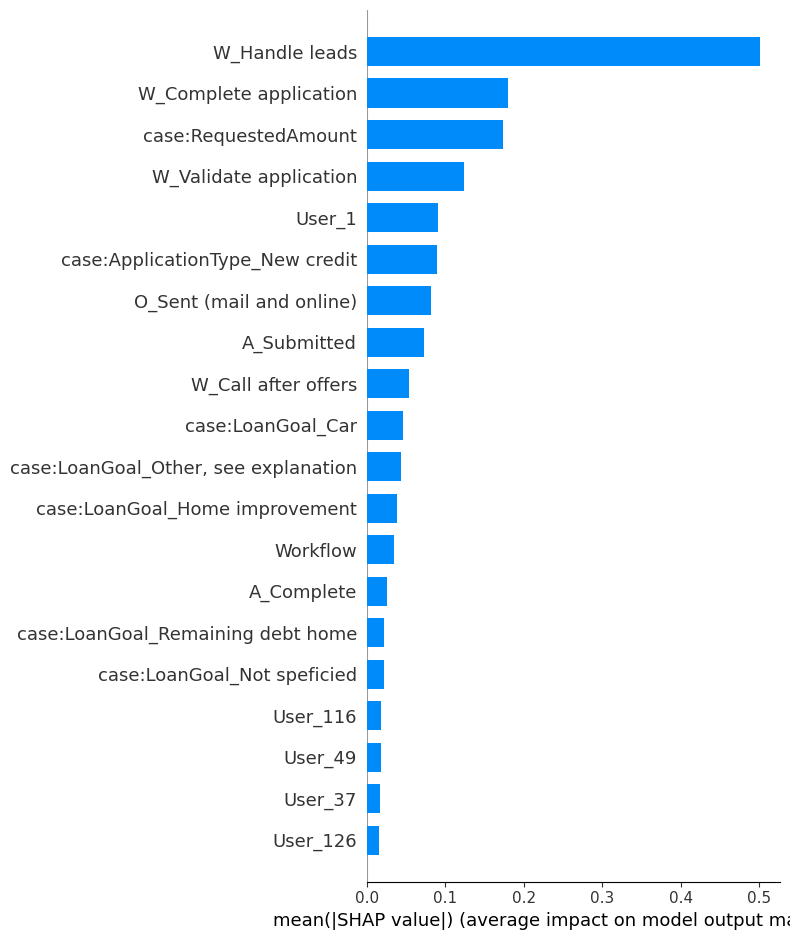

In [46]:
shap_values = shap.TreeExplainer(clf).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


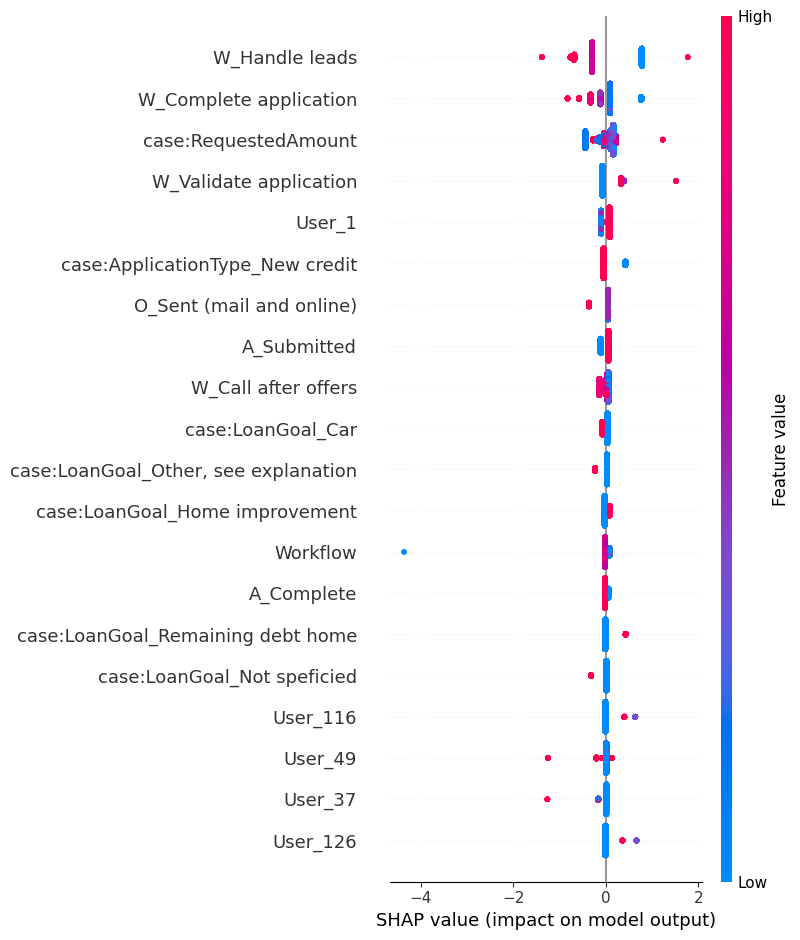

In [47]:
shap.summary_plot(shap_values, X_train)

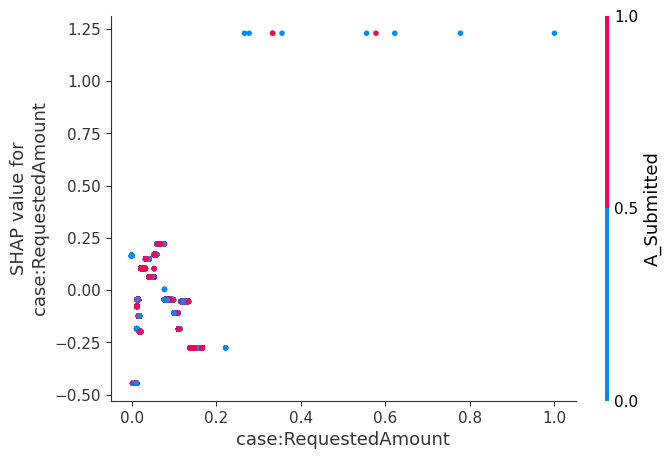

In [48]:
shap.dependence_plot('case:RequestedAmount', shap_values, X_train)

In [49]:
check = shap.Explanation(shap_values[0])

In [50]:
shap_values[0]

array([ 0.00000000e+00, -1.12146692e-01,  7.74922680e-01, -3.33208865e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.01367071e-03,
        4.63064764e-02,  2.13972973e-02, -1.65160194e-02,  0.00000000e+00,
        2.85823236e-03, -7.55256261e-02,  0.00000000e+00, -1.87592808e-03,
        0.00000000e+00,  6.20511537e-04,  0.00000000e+00, -1.03898739e-01,
        2.95035857e-04, -6.16381365e-04, -6.73744422e-04,  2.45142067e-03,
        9.52494411e-04, -2.96060085e-03,  4.42144587e-03,  4.00579210e-03,
       -9.24168088e-03, -6.25942872e-04,  8.16931363e-04,  2.79783400e-03,
        9.74593805e-04,  2.40307004e-03,  8.06279804e-03, -2.54606813e-03,
        2.91828555e-03,  2.40774479e-04, -2.81188819e-03,  5.65198021e-03,
        4.55423699e-05, -4.14172766e-03, -7.78717695e-04,  3.65547944e-03,
        0.00000000e+00, -3.52601061e-03, -9.34367237e-04, -1.17280173e-03,
        2.24856041e-03,  8.97197788e-03,  4.36800007e-04,  8.21495378e-04,
       -1.60877894e-04, -

In [51]:
explainer = shap.Explainer(clf, X_train)
shap_values = explainer(X_train)

 97%|=================== | 18863/19509 [00:29<00:00]       

In [52]:
shap_values[0]

.values =
array([ 0.00000000e+00, -1.14313961e-01,  7.83115312e-01, -3.75082124e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  8.18431288e-03,
        5.35039176e-02,  2.79756938e-02, -1.64065828e-02,  0.00000000e+00,
        0.00000000e+00, -6.92540061e-02,  0.00000000e+00, -5.80912352e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.10778075e-01,
        0.00000000e+00, -8.49318579e-04,  0.00000000e+00,  1.93633169e-03,
        0.00000000e+00, -1.89371675e-03,  0.00000000e+00,  7.11529136e-03,
       -4.06709537e-03, -2.58730471e-03,  5.52754231e-03,  2.40921840e-03,
        1.02878429e-03, -2.81581521e-03,  4.23506409e-03, -3.49797487e-03,
        0.00000000e+00,  0.00000000e+00,  1.15239501e-03,  1.44249294e-02,
        0.00000000e+00, -1.09190488e-02,  0.00000000e+00,  6.76870689e-03,
        0.00000000e+00, -1.39421411e-04,  1.91731229e-04, -1.13811679e-03,
       -8.87862146e-04,  8.69148225e-03,  2.17044726e-03,  7.23861635e-03,
        0.00000

In [53]:
shap_values[0]

.values =
array([ 0.00000000e+00, -1.14313961e-01,  7.83115312e-01, -3.75082124e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  8.18431288e-03,
        5.35039176e-02,  2.79756938e-02, -1.64065828e-02,  0.00000000e+00,
        0.00000000e+00, -6.92540061e-02,  0.00000000e+00, -5.80912352e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.10778075e-01,
        0.00000000e+00, -8.49318579e-04,  0.00000000e+00,  1.93633169e-03,
        0.00000000e+00, -1.89371675e-03,  0.00000000e+00,  7.11529136e-03,
       -4.06709537e-03, -2.58730471e-03,  5.52754231e-03,  2.40921840e-03,
        1.02878429e-03, -2.81581521e-03,  4.23506409e-03, -3.49797487e-03,
        0.00000000e+00,  0.00000000e+00,  1.15239501e-03,  1.44249294e-02,
        0.00000000e+00, -1.09190488e-02,  0.00000000e+00,  6.76870689e-03,
        0.00000000e+00, -1.39421411e-04,  1.91731229e-04, -1.13811679e-03,
       -8.87862146e-04,  8.69148225e-03,  2.17044726e-03,  7.23861635e-03,
        0.00000

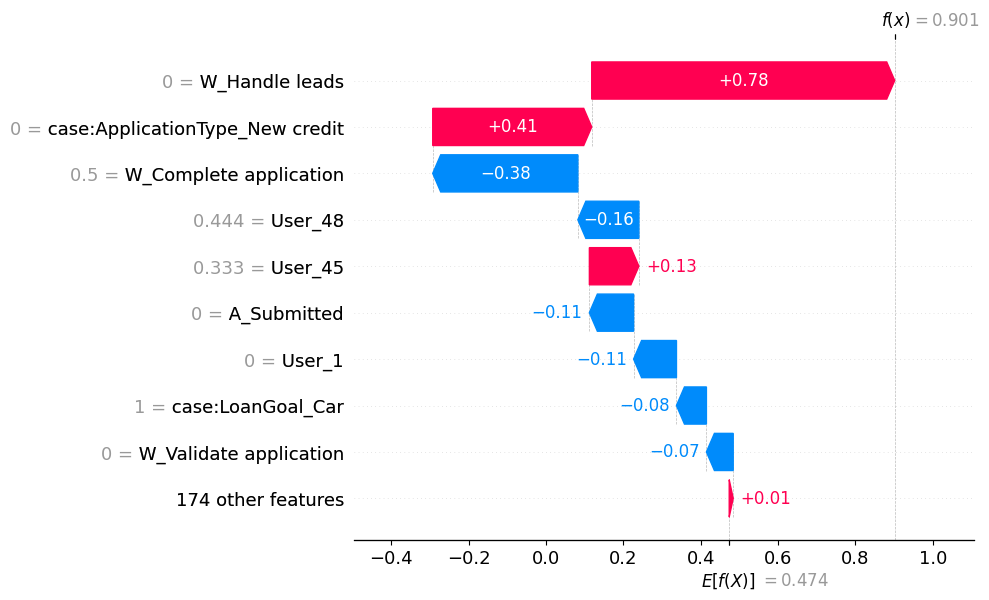

In [54]:
shap.plots.waterfall(shap_values[0])

Erklärung für einen Datenpunkt !

In [55]:
shap_values = explainer.shap_values(new_df_data)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


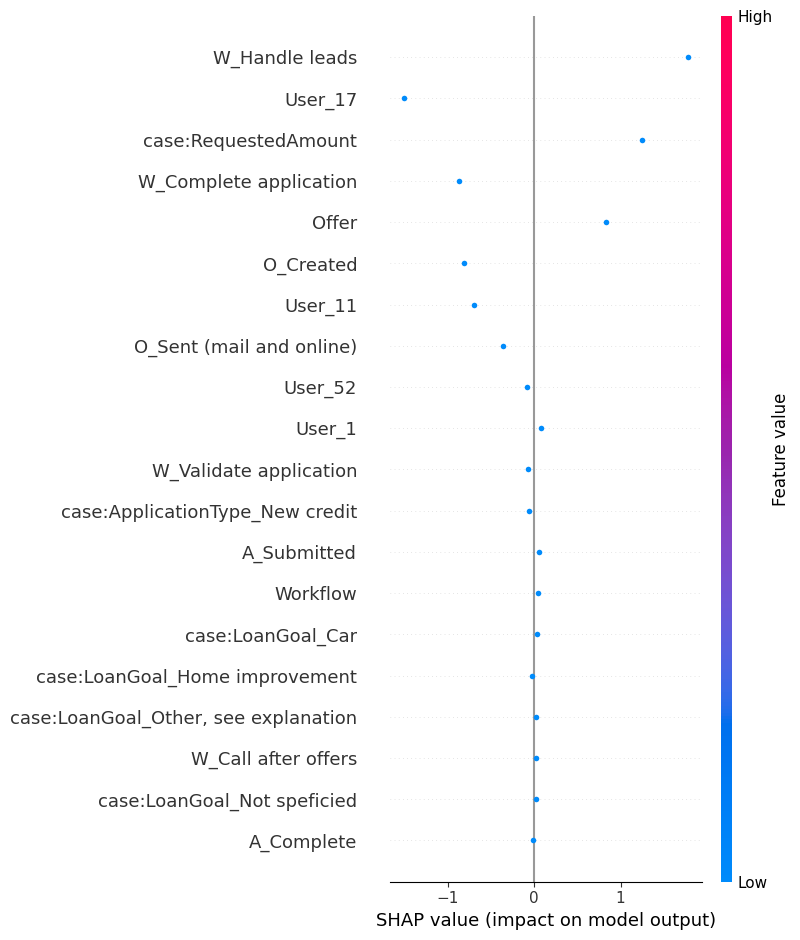

In [56]:
shap.summary_plot(shap_values, new_df_data)


In [57]:
shap.force_plot(explainer.expected_value,
                shap_values[0],
                new_df_data)


In [1]:
shap.decision_plot(explainer.expected_value, shap_values[0], new_df_data)


NameError: ignored

In [59]:
shap.plots.beeswarm(shap_values)


TypeError: ignored

#Evaluation noch alter Code, muss angepasst werden

In [ ]:
test_dataloader = DataLoader(data, batch_size=256, shuffle=False)
result, original = evaluate_all(test_dataloader, clf, device)

  0%|          | 0/123 [00:00<?, ?it/s]

Text(0, 0.5, 'Score')

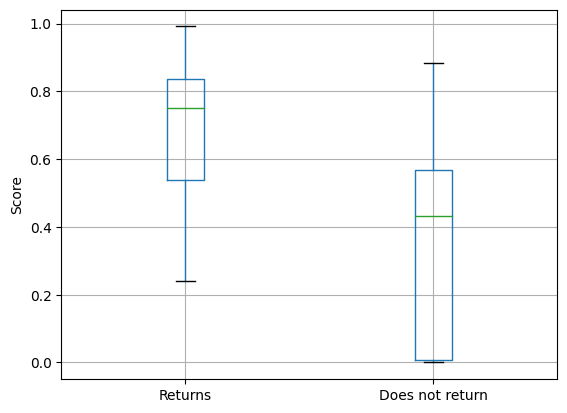

In [ ]:
pd_pos = pd.DataFrame({'Returns': result[original == 1]})
pd_neg = pd.DataFrame({'Does not return': result[original == 0]})
pd.concat([pd_pos, pd_neg],axis=1).boxplot().set_ylabel('Score')

Text(0, 0.5, 'Frequency')

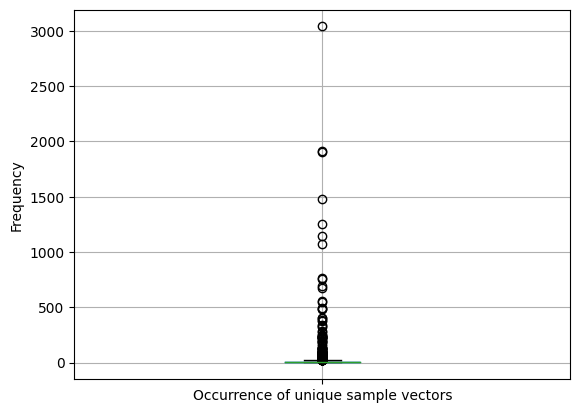

In [ ]:
# count the unique vectors
dist_bags = np.unique(data_bag, return_counts=True, axis=0)

# sort them with numpy
unique_vectors = dist_bags[0][np.argsort(-dist_bags[1])]
count_vectors = dist_bags[1][np.argsort(-dist_bags[1])]

pd.DataFrame({'Occurrence of unique sample vectors': count_vectors}).boxplot().set_ylabel('Frequency')

In [ ]:
# most frequently used vector
unique_vectors[0]

array([1, 0, 0, 3, 1, 1, 1, 1, 1, 6, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0])

In [ ]:
# find the sample indicies for this vector
sample_indicies = np.where((data_bag == unique_vectors[0]).all(axis=1))
sample_durations = target_scaled[sample_indicies]

In [ ]:
np.unique(sample_durations, return_counts=True)

(array([0, 1]), array([ 504, 2536]))